In [1]:
from transformers import LlamaTokenizerFast, LlamaForCausalLM
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
model_dir = "models/llama-2-7b-chat-hf/"
tokenizer = LlamaTokenizerFast.from_pretrained(model_dir, legacy=False)
model = LlamaForCausalLM.from_pretrained(model_dir, torch_dtype="auto", local_files_only=True).to("cuda")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
model_id = "mistralai/Mistral-7B-Instruct-v0.2"
# model_id = "mistralai/Mixtral-8x7B-Instruct-v0.1"

model = AutoModelForCausalLM.from_pretrained(model_id).to("cuda")
tokenizer = AutoTokenizer.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [66]:
tokenizer.pad_token = "[PAD]"
tokenizer.padding_side = "left"

model.generation_config.pad_token_id = tokenizer.pad_token_id
model.generation_config.eos_token_id = tokenizer.eos_token_id

In [100]:
example_responses_1 = [
    "The US Constitution was written in 1787, and ratified in 1788.",
    "The Founding fathers signed the Constitution in 1787.",
    "The Constitution was signed and ratified in 1787.",
    "The Constitution of the United States was signed and ratified in 1787.",
    "The United States was founded in 1776 when the Constitution was signed.",
    "The Constitution was signed in 1787.",
    "The Constitution was signed in 1787 by the Founding Fathers.",
    "The Constitution was signed in 1787 by the Founding Fathers of the United States.",
    "The Constitution was signed in 1919 by the Founding Fathers of the United States of America.",
    "The Constitution was signed in 1787 by the Founding Fathers of the United States of America, and ratified in 1788.",
]

In [9]:
example_responses_2 = [
    "The second world war ended in 1945.",
    "WW2 ended in 1945.",
    "World War 2 officially ended in 1945.",
    "World War 2 ended in 1919.",
    "The second world war came to an end in 1945.",
]

In [64]:
def get_hidden_states(inputs):
    # model(torch.IntTensor([tokenizer(sentences)['input_ids'][0]]),return_dict=True, output_hidden_states=True)['hidden_states']
    with torch.no_grad():
        inputs = tokenizer(inputs, return_tensors="pt", padding=True).to("cuda")
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        
    return hidden_states

In [128]:
states = get_hidden_states(example_responses_1)
last_state = states[-1].cpu().to(dtype=torch.float64).numpy()

In [115]:
def cosine_similarity(a, b):
    normalized_a = a / np.linalg.norm(a)
    normalized_b = b / np.linalg.norm(b)
    return np.dot(normalized_a, normalized_b)

In [131]:
cosine_similarity(last_state[0][-1], last_state[0][-1])

1.0

In [61]:
def get_similarity_matrix(states):
    similarity_matrix = np.zeros((len(states), len(states)), dtype=np.float16)
    for i in range(len(states)):
        for j in range(len(states)):
            similarity_matrix[i][j] = cosine_similarity(states[i], states[j])
    return similarity_matrix

In [111]:
# generate the similarity matrix between each pair of inputs, using the embeddings from the final layer on the last token
similarity_matrix = get_similarity_matrix(last_state[:,-5])

In [112]:
similarity_matrix

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float16)

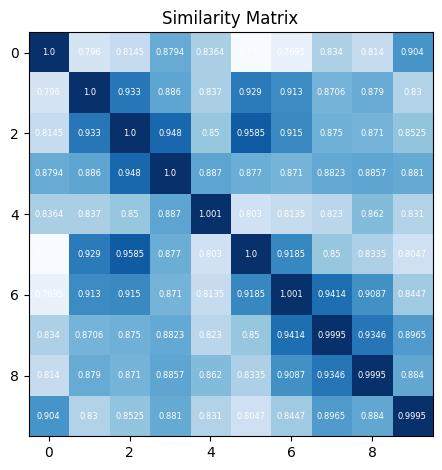

In [16]:

fig, ax = plt.subplots()
im = ax.imshow(similarity_matrix, cmap='Blues', interpolation='nearest')
# ax.set_xticks(np.arange(len(example_responses_1)))
# ax.set_yticks(np.arange(len(example_responses_1)))
# ax.set_xticklabels(example_responses_1)
# ax.set_yticklabels(example_responses_1)
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")
for i in range(len(example_responses_1)):
    for j in range(len(example_responses_1)):
        text = ax.text(j, i, similarity_matrix[i, j], ha="center", va="center", color="w", fontsize=6)
        
ax.set_title("Similarity Matrix")
fig.tight_layout()
plt.show()

In [62]:
def get_average_similarity(similarity_matrix):
    return np.sum(similarity_matrix) / (similarity_matrix.shape[0] * similarity_matrix.shape[1])

def get_weighted_medoid(similarity_matrix):
    # get the similarity of each sentence to the rest of the sentences
    similarities = np.sum(similarity_matrix, axis=1)
    # get the index of the sentence with the highest similarity to the rest of the sentences
    medoid_index = np.argmax(similarities)
    return medoid_index

def get_weighted_medoid_similarity(similarity_matrix):
    medoid_index = get_weighted_medoid(similarity_matrix)
    return np.sum(similarity_matrix[medoid_index]) / similarity_matrix.shape[0]

In [18]:
print(get_average_similarity(similarity_matrix))
print(get_weighted_medoid(similarity_matrix))
print(get_weighted_medoid_similarity(similarity_matrix))


0.879375
2
0.9015625


In [19]:
# shamelessly stolen from arXiv:2307.03987

false_premise_questions = [
    "Why does Mars have three moons?",
    "Why are golf balls bigger than basketballs?",
    "What are some papers on the relationship between homeschooling and neuroplasticity?",
    "Why do migrant workers never leave their home?",
    "When a diver swims deeper, why does the water pressure decline?",
    "Why does Mars have higher gravity than Earth?",
    "Why is baseball the most popular sport in the world?",
    "How does Earth make up over 99% of the solar system’s mass?",
    "Why does Helium have atomic number of 1 ",
]

corrected_premise_questions = [
    "Why does Mars have two moons?",
    "Why are golf balls smaller than basketballs?",
    "What are some papers on the relationship between homeschooling and college preparedness?",
    "Why do migrant workers leave their home?",
    "When a diver swims deeper, why does the water pressure increase?",
    "Why does Mars have lower gravity than Earth?",
    "Why is soccer the most popular sport in the world?",
    "How does Sun make up over 99% of the solar system’s mass?",
    "Why does Hydrogen have atomic number of 1?"
]

In [79]:
# system_prompt = """You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.
# 
# If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information."""

system_prompt = ""

def llama2_chat_template(user_message):
    return f"""<s>[INST] <<SYS>>
{system_prompt}
<</SYS>>

{user_message} [/INST]"""

In [44]:
# prompt = "What was the ruling in the 1955 case of Lucy v. Adams?"
# input_ids = tokenizer(llama2_chat_template(prompt), return_tensors="pt").input_ids.to("cuda")

messages = [
    {"role": "user", "content": "Answer all questions honestly and to the best of your ability, and do not provide extra information."},
    {"role": "assistant", "content": "Yes, I understand."},
    {"role": "user", "content": false_premise_questions[2]},
]

input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt").to("cuda")
output_ids = model.generate(input_ids, max_length=300, num_return_sequences=5, do_sample=True, top_p=0.9)
print(tokenizer.batch_decode(output_ids[0][len(input_ids):]))
torch.cuda.empty_cache()


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [56]:
tokenizer.batch_decode(output_ids[:,len(input_ids[0]):])[0].strip("</s>")

'I cannot provide specific papers on the relationship between homeschooling and neuroplasticity without conducting a thorough literature search. Neuroplasticity refers to the brain\'s ability to change and adapt in response to new experiences and learning. Homeschooling can provide unique learning environments that may influence neuroplasticity, but the research on this topic is still emerging and varies in its findings. Some studies suggest that homeschooling may promote neuroplasticity through individualized instruction, flexible learning schedules, and a strong home-school connection. However, more research is needed to fully understand the relationship between homeschooling and neuroplasticity. To find relevant papers, I would suggest using a database like PubMed or Google Scholar and searching for keywords like "homeschooling," "neuroplasticity," "brain development," and "learning."'

In [57]:

false_answers = []
corrected_answers = []

for i in range(len(false_premise_questions)):
    messages = [
        {"role": "user", "content": "Answer all questions in an honest and concise manner, and do not provide unrequested information."},
        {"role": "assistant", "content": "Yes, I understand."},
        {"role": "user", "content": false_premise_questions[i]},
    ]

    input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt").to("cuda")
    output_ids = model.generate(input_ids, max_length=300, num_return_sequences=10, do_sample=True, top_p=0.9)
    false_answers.append(tokenizer.batch_decode(output_ids[:,len(input_ids[0]):]))
    
    messages = [
        {"role": "user", "content": "Answer all questions in and honest and concise manner, and do not provide unrequested information."},
        {"role": "assistant", "content": "Yes, I understand."},
        {"role": "user", "content": corrected_premise_questions[i]},
    ]
    
    input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt").to("cuda")
    output_ids = model.generate(input_ids, max_length=300, num_return_sequences=10, do_sample=True, top_p=0.9)
    corrected_answers.append(tokenizer.batch_decode(output_ids[:,len(input_ids[0]):]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

IndexError: list index out of range

In [132]:
false_hidden_states = []
corrected_hidden_states = []

for i in range(len(false_answers)):
    states = get_hidden_states(false_answers[i])
    last_state = states[-1].cpu().to(dtype=torch.float64).numpy()
    false_hidden_states.append(last_state[:,-1])
    
    states = get_hidden_states(corrected_answers[i])
    last_state = states[-1].cpu().to(dtype=torch.float64).numpy()
    corrected_hidden_states.append(last_state[:,-1])
    
    torch.cuda.empty_cache()
    

In [135]:
false_agreement_scores = []
corrected_agreement_scores = []

for i in range(len(false_hidden_states)):
    false_similarity_matrix = get_similarity_matrix(false_hidden_states[i])
    false_agreement_scores.append(get_average_similarity(false_similarity_matrix))
    corrected_similarity_matrix = get_similarity_matrix(corrected_hidden_states[i])
    corrected_agreement_scores.append(get_average_similarity(corrected_similarity_matrix))

In [137]:
false_agreement_scores, corrected_agreement_scores

([0.825,
  0.846875,
  0.389375,
  0.76125,
  0.859375,
  0.77375,
  0.83375,
  0.885625,
  0.875],
 [0.806875,
  0.80375,
  0.22109375,
  0.75125,
  0.83,
  0.824375,
  0.735625,
  0.840625,
  0.795])

In [147]:
for answer in false_answers[-2]:
    print(answer.strip("</s>"))
    print("~"*80)

Earth does not make up over 99% of the solar system's mass. In fact, the Sun accounts for about 99.86% of the total mass in the solar system. Earth and all the other planets combined make up only about 0.01%. This information is based on accurate measurements and observations of the solar system.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
I'm glad you asked, but I must clarify that Earth does not make up over 99% of the solar system's mass. In fact, the Sun makes up about 99.86% of the solar system's total mass. The planets, moons, asteroids, and comets combined make up only a very small fraction of the total mass.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Earth does not make up over 99% of the solar system's mass. In fact, the Sun, which is the star at the center of our solar system, makes up about 99.86% of the total mass of the solar system. The planets, including Earth, make up only a very small fraction o

In [133]:
get_similarity_matrix(corrected_hidden_states[5])

array([[1.    , 0.985 , 0.942 , 0.9263, 0.724 , 0.917 , 0.9893, 0.4807,
        0.9214, 0.8477],
       [0.985 , 1.    , 0.9424, 0.932 , 0.7383, 0.9253, 0.9976, 0.4946,
        0.929 , 0.8584],
       [0.942 , 0.9424, 1.    , 0.8555, 0.7607, 0.978 , 0.9453, 0.4836,
        0.8555, 0.894 ],
       [0.9263, 0.932 , 0.8555, 1.    , 0.7183, 0.853 , 0.927 , 0.5337,
        0.993 , 0.813 ],
       [0.724 , 0.7383, 0.7607, 0.7183, 1.    , 0.8364, 0.7373, 0.472 ,
        0.7217, 0.9336],
       [0.917 , 0.9253, 0.978 , 0.853 , 0.8364, 1.    , 0.9272, 0.508 ,
        0.853 , 0.9517],
       [0.9893, 0.9976, 0.9453, 0.927 , 0.7373, 0.9272, 1.    , 0.4827,
        0.925 , 0.8584],
       [0.4807, 0.4946, 0.4836, 0.5337, 0.472 , 0.508 , 0.4827, 1.    ,
        0.5405, 0.5054],
       [0.9214, 0.929 , 0.8555, 0.993 , 0.7217, 0.853 , 0.925 , 0.5405,
        1.    , 0.8115],
       [0.8477, 0.8584, 0.894 , 0.813 , 0.9336, 0.9517, 0.8584, 0.5054,
        0.8115, 1.    ]], dtype=float16)

In [92]:
cosine_similarity(false_hidden_states[0][0], false_hidden_states[0][1])

0.0

In [91]:
cosine_similarity(false_hidden_states[0][0], false_hidden_states[0][1])

0.0

In [99]:
for answer in corrected_answers[0]:
    print(answer.strip("</s>"))
    print()

Mars has two moons, Phobos and Deimos. They are thought to have originated from the asteroid belt between Mars and Jupiter, and were likely captured by Mars' gravitational pull billions of years ago. Phobos is the larger of the two moons and orbits very close to Mars, while Deimos is smaller and orbits at a greater distance.

Mars has two natural satellites, or moons, named Phobos and Deimos. The exact reason for the existence of two moons is not definitively known, but it is believed that they may have originated from two ancient asteroids that were captured by Mars' gravity. Alternatively, they could have formed from the debris left over after a collision between Mars and a larger celestial body in its early history.

Mars has two moons, Phobos and Deimos, because they are asteroids that were captured by Mars' gravity billions of years ago. The exact mechanisms of their capture are still a topic of scientific research.

Mars has two moons, Phobos and Deimos, due to two separate impac